# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [329]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [330]:
# load the training, development and test sets 
training = pd.read_csv('data_topic/train.csv',header=-1)
development = pd.read_csv('data_topic/dev.csv',header=-1)
test_sets = pd.read_csv('data_topic/test.csv',header=-1)

In [331]:
# put the raw texts into Python lists
train_list=training.values.tolist()
development_list=development.values.tolist()
test_sets_list=test_sets.values.tolist()

In [332]:
def get_rawX(data):
    rawlist=[]
    for i in range(0,len(data)):
        rawlist.append(data[i][1])
        #print(data[i][0])
    return rawlist#  a list of s

In [333]:
train_raw=get_rawX(train_list)
dev_raw=get_rawX(development_list)
test_raw=get_rawX(test_sets_list)

In [637]:
# All words in lowercase
train_raw = [s.lower() for s in train_raw if isinstance(s,str)]
dev_raw = [s.lower() for s in dev_raw if isinstance(s,str)]
test_raw = [s.lower() for s in test_raw if isinstance(s,str)]

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [638]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [639]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    a=re.findall(token_pattern,x_raw)
    resultlist=[]
    b=[]
    #remove stoplist
    for i in a:
        if i not in stop_words:
            b.append(i)
    
    for i in b:
        resultlist.append(i) 
        
    if ngram_range==(1,2):
        i=0
        for i in range(0,len(b)-1):
            tuble=(b[i],b[i+1])
            resultlist.append(tuble)
            
    if ngram_range==(1,3):
        i=0
        for i in range(0,len(b)-1):
            tuble=(b[i],b[i+1])
            
            resultlist.append(tuble)  
        j=0
        for j in range(0,len(b)-2):
            tuble=(b[j],b[j+1],b[j+2])
            resultlist.append(tuble)
    if vocab==set():    
        return resultlist  
    else:
        resultlist2=[]
        for i in resultlist:
            if i in vocab:
                resultlist2.append(i)
        return resultlist2



### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [640]:
def get_vocab(X_raw, ngram_range=(1,2), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    

    #Calculate NGram in all files，No repetitive NGram removed
    all_ngrams=[]
    ngrams_list=[]
    for s in X_raw:
        ngrams_one=extract_ngrams(s, ngram_range=ngram_range,stop_words=stop_words)
        all_ngrams.extend(ngrams_one)
        ngrams_list.append(ngrams_one)

    #get  ngram_counts
    Counter_ngrams=Counter(all_ngrams) #Total frequency of each NGram
    ngram_counts=Counter_ngrams.most_common(keep_topN)   
    #gey  vocab
    vocab=[]
    for i in range (0,keep_topN):
        vocab.append(ngram_counts[i][0])
        
    #  Disorganize vocab
    vocab=list(set(vocab))
        
        

    df={}
    for i in vocab:
        count=min_df        
        for j in range(0,len(ngrams_list)):#  Loop through all files
            
            if i in ngrams_list[j]:     #If there is NGram in this file
                count=count+1
        df[i]=count
        
        
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [641]:
vocab_train, df_train, ngram_counts_train = get_vocab(train_raw, ngram_range=1, keep_topN=8000, stop_words=stop_words)

In [642]:
len(vocab_train)

8000

In [643]:
vocab_train

['houses',
 'boycott',
 'superiority',
 'how',
 'guerrillas',
 'columbus',
 'cave',
 'motor',
 'weapons',
 'superb',
 'klete',
 'little',
 'battleground',
 'rainy',
 'running',
 'nicholls',
 'islamic',
 'iliadis',
 'surrender',
 'retired',
 'masterminded',
 'instance',
 'appear',
 'floods',
 'deutsche',
 'fastest',
 'mutual',
 'hagen',
 'wait',
 'association',
 'shouldn',
 'broaden',
 'recognized',
 'warplane',
 'colombian',
 'report',
 'kabul',
 'dazzling',
 'agreed',
 'describe',
 'teenager',
 'financial',
 'excavated',
 'pleasant',
 'saves',
 'voting',
 'tiny',
 'nottinghamshire',
 'judicial',
 'wasn',
 'easy',
 'palms',
 'dare',
 'moldovan',
 'divided',
 'stores',
 'saying',
 'outlasts',
 'skyrocket',
 'far',
 'nl',
 'death',
 'revealed',
 'chanting',
 'abby',
 'matters',
 'facemask',
 'face',
 'saw',
 'finances',
 'entertained',
 'oprah',
 'era',
 'motors',
 'sa',
 'czar',
 'turning',
 'awakes',
 'guided',
 'rape',
 'guzman',
 'colombia',
 'reflected',
 'nicol',
 'prospect',
 'sav

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [645]:
vocabulary_id_word={}#  id :word
vocabulary_word_id={}
t=0
for w in vocab_train:
    vocabulary_id_word[t]=w
    vocabulary_word_id[w]=t
    t=t+1

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [646]:
def get_X_uni(X_raw,vocab_train,ngram_range=1):
    
    X_uni_tr=[]
    for s in X_raw:
        ngrams_one_=[]
        ngrams_one=extract_ngrams(s, ngram_range=ngram_range,stop_words=stop_words)
        #remove some word in ngrams_one
        for i in ngrams_one:
            if i in vocab_train:
                ngrams_one_.append(i)
               
        X_uni_tr.append(ngrams_one_)
    return X_uni_tr

In [647]:
X_uni_tr=get_X_uni(train_raw,vocab_train,ngram_range=1)

In [648]:
X_uni_dev=get_X_uni(dev_raw,vocab_train,ngram_range=1)

In [649]:
X_uni_test=get_X_uni(test_raw,vocab_train,ngram_range=1)

Then convert them into lists of indices in the vocabulary:

In [650]:
def get_X_tr(X_uni_tr):
    X_tr=[]
    for i in range(0,len(X_uni_tr)):
        x_one=[]
        for j in X_uni_tr[i]:
              
            x_one.append(vocabulary_word_id[j]) # not in vocabulary_word_id，but in X_uni_tr
        X_tr.append(x_one)
    return X_tr
        
    
    

In [651]:
X_tr=get_X_tr(X_uni_tr)

In [652]:
X_dev=get_X_tr(X_uni_dev)

In [653]:
X_test=get_X_tr(X_uni_test)

In [654]:
X_tr[0]

[6581,
 6388,
 3627,
 4563,
 1075,
 3098,
 7707,
 1663,
 1380,
 2451,
 5412,
 7668,
 261,
 510,
 1176,
 2743,
 3954,
 1653,
 2627,
 5890,
 4705,
 4271,
 984,
 5995,
 3808,
 2309,
 1824]

Put the labels `Y` for train, dev and test sets into arrays: 

In [655]:
def get_Y(data):
    Ylist=[]
    for i in range(0,len(data)):
        Ylist.append(data[i][0])
       
    return Ylist#  a list of s

In [656]:
Y_train=get_Y(train_list)

In [657]:
Y_dev=get_Y(development_list)

In [658]:
Y_test=get_Y(test_sets_list)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [351]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    W=[]
    if len(hidden_dim)==0:        
        w_emb = np.random.uniform(-0.5,0.5,size=[vocab_size,embedding_dim])
        W.append(w_emb)
        w_out=np.random.uniform(-0.5,0.5,size=[embedding_dim,num_classes])
        W.append(w_out)
    else:
        w_emb = np.random.uniform(-0.5,0.5,size=[vocab_size,embedding_dim])
        W.append(w_emb)
        w_h1=np.random.uniform(-0.5,0.5,size=[embedding_dim,hidden_dim[0]])
        W.append(w_h1)                                 
        for  i in range(0,len(hidden_dim)):
           
            if i==(len(hidden_dim)-1):
               
                w_hidden=np.random.uniform(-0.5,0.5,size=[hidden_dim[i],num_classes])
                W.append(w_hidden)
            else:                             
                w_hidden=np.random.uniform(-0.5,0.5,size=[hidden_dim[i],hidden_dim[i+1]])
                W.append(w_hidden)
                                         
    return W
    

In [352]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [353]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [354]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [355]:
W[0]

array([[-0.40428748,  0.38532683,  0.12724897,  0.22341636],
       [-0.48387079,  0.09443188,  0.05678519, -0.34104036],
       [-0.34692948,  0.19552953, -0.18123357,  0.1919703 ]])

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [356]:
def softmax1(z):
    
    smax=[]
    if z.ndim==1:
  
        smax = (np.exp(z))/(np.sum(np.exp(z)))
    else:
        smax = (np.exp(z))/(np.sum(np.exp(z),axis=1).reshape(-1,1))
        
    return smax

In [357]:
def softmax(x):

    x = x - np.max(x)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

 Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [358]:
def categorical_loss(y, y_preds):


    for i in range(1,(len(y_preds)+1)):
        if y==i:

            l=-np.log(y_preds[i-1])

       
    return l

In [359]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.3080264848567502


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [360]:

def relu(z):
    x=z.copy()
    for i in range(0,len(x)):
        if x[i]<0:
            x[i]=0
        
    return x
    

def relu_derivative(z):
    dz=z.copy()
    
    for i in range(0,len(dz)):
        
            if dz[i]<=0:
                dz[i]=0
            if dz[i]>0:
                dz[i]=1
   
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [361]:
def dropout_mask(size, dropout_rate):
    
    numn_0=int(dropout_rate*size)
    dropout_vec = np.ones(size)
    dropout_vec[:numn_0] = 0
    np.random.shuffle(dropout_vec)
    
    return dropout_vec
    
    

In [362]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 0. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [364]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[5], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)        

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 5)
Shape W2 (5, 2)

{'h': [array([-0.04668262, -0.12518335,  0.17532285, -0.32932054]), array([-0.01851934,  0.04051238, -0.05942235,  0.01765476,  0.0641444 ])], 'a': [array([0.        , 0.        , 0.17532285, 0.        ]), array([0.        , 0.04051238, 0.        , 0.01765476, 0.0641444 ])], 'd': [array([1., 0., 1., 0.]), array([0., 0., 1., 1., 1.])], 'y': array([0.48946732, 0.51053268])}


In [ ]:
def forward_pass(x, W, dropout_rate=0.2):
        
    out_vals = {}
    
    # how many w
    k=len(W)
    
    # first layer
    h_vecs = [W[0][x].sum(axis=0)/len(x)]
    a_vecs = [relu(h_vecs[0])]
    dropout_vecs = [dropout_mask(W[0].shape[1],dropout_rate)]
    
    # other layer
    for i in range(1,k-1):
        h_vecs.append(np.matmul(a_vecs[i-1]*dropout_vecs[i-1],W[i]))
        
        a_vecs.append(relu(h_vecs[i]))
        
        dropout_vecs.append(dropout_mask(W[i].shape[1],dropout_rate))
        
    y=softmax(np.matmul(a_vecs[-1]*dropout_vecs[-1],W[k-1]))
    
    
       
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['d'] = dropout_vecs
    out_vals['y'] = y
    
    return out_vals

The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [609]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    y_p=out_vals['y']
    h=out_vals['h']
    d=out_vals['d']
    a=out_vals['a']
    
    # get g
    y_onehot=np.zeros_like(y_p)
    y_onehot[y-1]=1
    g=y_p-y_onehot
    
    for i in range(len(W)-1,0,-1):
        W_d=np.outer(a[i-1]*d[i-1],g)
        W_new=W[i]-lr*W_d
        g=np.matmul(g,W[i].T)
        W[i]=W_new
        g=g*relu_derivative(h[i-1])
      
    #if need to update emb layer    
    if  freeze_emb==False:
        for wordid in x:
        
            W[0][wordid]=W[0][wordid]-lr*g/len(x)
            
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [582]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.01, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    
    training_loss_history=[]
    validation_loss_history=[]
    
    for j in range(0,epochs): 
        
        loss_epoch_train=0
      
        for i in range(0,len(X_tr)):   
            

          
                
            layer_outputs_train = forward_pass(X_tr[i],W,dropout_rate=dropout)
            
            # compute loss
            loss_train_=categorical_loss(Y_tr[i],layer_outputs_train['y'])
          
            loss_epoch_train=loss_epoch_train+loss_train_
         
            #  backward_pass  update W
            W=backward_pass(X_tr[i], Y_tr[i], W, layer_outputs_train, lr=lr, freeze_emb=False)   
            
          
            

        #  dev loss      
        loss_epoch_dev=0    
        for m in range(0,len(X_dev)):            
         
            layer_outputs_dev = forward_pass(X_dev[m],W,dropout_rate=dropout)
            loss_dev_=categorical_loss(Y_dev[m],layer_outputs_dev['y'])
            loss_epoch_dev+=loss_dev_
             
            
         
        loss_train=loss_epoch_train/len(X_tr)
        loss_dev=loss_epoch_dev/len(X_dev)

        training_loss_history.append(loss_train)
        validation_loss_history.append(loss_dev)
    
        print('train loss:',loss_train,'dev loss:',loss_dev)

    
    
    
    
    
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [680]:

W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_train,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.01, 
                            dropout=0.4,
                            freeze_emb=False,
                            tolerance=0.01,   
                            epochs=40)

Shape W0 (8000, 300)
Shape W1 (300, 3)
train loss: 1.0745520450138664 dev loss: 1.1177999818746105
train loss: 1.0472133692615184 dev loss: 1.102018272162284
train loss: 1.021455326308294 dev loss: 1.0741253976719938
train loss: 0.9984310298129425 dev loss: 1.0543420628912212
train loss: 0.9638401416954815 dev loss: 1.025018926267671
train loss: 0.9367917350565768 dev loss: 1.0181085361505964
train loss: 0.9044367210149905 dev loss: 1.0036692568528187
train loss: 0.8738388667554083 dev loss: 0.9822880397207374
train loss: 0.8394050691131235 dev loss: 0.9476375802814101
train loss: 0.8034130929344238 dev loss: 0.9310531609358346
train loss: 0.7656888666706257 dev loss: 0.8923344347372463
train loss: 0.7379346195822959 dev loss: 0.8723828159250848
train loss: 0.699481110416521 dev loss: 0.8626944817237027
train loss: 0.667398911901719 dev loss: 0.812326883955915
train loss: 0.6351872909597769 dev loss: 0.7846447209521563
train loss: 0.6091985083135067 dev loss: 0.7694804481010131
train l

#### Plot the learning process:

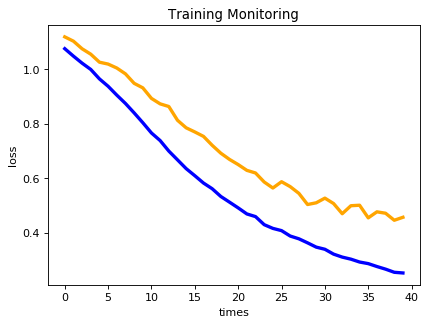

In [681]:
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4.3), dpi=80)
plt.title("Training Monitoring")
plt.xlabel("times")
plt.ylabel("loss")



plt.plot(loss_tr,color='blue',linewidth=3.0)
plt.plot(dev_loss,color='orange',linewidth=3.0)


plt.show()

Compute accuracy, precision, recall and F1-Score:

In [682]:
Y_test=get_Y(test_sets_list)
Y_test = [i-1 for i in Y_test]

In [683]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,Y_test)]
print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8422222222222222
Precision: 0.8438186586378614
Recall: 0.8422222222222223
F1-Score: 0.8417679481713213


### Discuss how did you choose model hyperparameters ? 

In [ ]:
# When i use lr= 0.005,Loss is falling very slowly.
#So I decided to increase the value of lr.


# When i use lr= 0.1,the loss  value will fluctuate when it drops to 0.3, but it will not drop.
# I think we should reduce the learning rate at this time.
#If the learning rate is set too small, the convergence rate will be greatly reduced and the training time will be increased; 
#if the learning rate is too large, the parameters may oscillate back and forth on both sides of the optimal solution.

#  When dropout = 0.2, the loss gap between traindata and dev data is 0.3
#  When dropout = 0.4, the loss gap between traindata and dev data is only 0.2，but then become bigger
# But use dropout = 0.4,the Accuracy inceeased from 0.82 to 0.84 ,so i choose to use dropout = 0.4.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [670]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab_train:

                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [671]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",vocabulary_word_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [687]:
#    initialise the weights of  network :

W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[], num_classes=3)

# replace the weigths of the embedding matrix with w_glove :

W[0] =w_glove

#  rain the network by freezing the embedding weights :

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_train,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.4,
                            freeze_emb=True,
                            tolerance=0.01,
                            epochs=40)

Shape W0 (8000, 300)
Shape W1 (300, 3)
train loss: 1.0146095589535156 dev loss: 1.0462236786705745
train loss: 0.9533227014921215 dev loss: 1.117378066918444
train loss: 0.9316880877840475 dev loss: 1.0546458497285582
train loss: 0.8982102189839223 dev loss: 0.9878661265445424
train loss: 0.8527271338321345 dev loss: 0.9489693597334359
train loss: 0.8207514433632603 dev loss: 0.9112836570148392
train loss: 0.7962046891842504 dev loss: 0.8863519707588834
train loss: 0.7683545176381337 dev loss: 0.8644412548305297
train loss: 0.7431257367341848 dev loss: 0.825261374153186
train loss: 0.7236558782389844 dev loss: 0.7950691293040999
train loss: 0.6969533183919697 dev loss: 0.8232151402367152
train loss: 0.6833977451601335 dev loss: 0.7678175553280243
train loss: 0.6599306974624355 dev loss: 0.7383008428079401
train loss: 0.6548281293939799 dev loss: 0.7114198977186255
train loss: 0.6365548839648557 dev loss: 0.7116608744482115
train loss: 0.6205509743525681 dev loss: 0.6382414239649336
tra

In [688]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,Y_test)]
print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.88
Precision: 0.8859626508289834
Recall: 0.88
F1-Score: 0.8787955847081022


### Discuss how did you choose model hyperparameters ? 

In [ ]:
# When i use lr= 0.005,Loss is falling very slowly.
#So I decided to increase the value of lr.

# When i use lr= 0.1,the loss  value will fluctuate when it drops to 0.3, but it will not drop.
# I think we should reduce the learning rate at this time.


# I choose epochs=40,because ,i find that after 30 epochs,with the increase of epochs, accuracy did not increase significantly


#  When dropout = 0.2, the loss gap between traindata and dev data is 0.3
#  When dropout = 0.4, the loss gap between traindata and dev data is only 0.2，but then become bigger
# But use dropout = 0.4,the Accuracy inceeased from 0.82 to 0.84 ,so i choose to use dropout = 0.4.

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [698]:
#    initialise the weights of  network :

W = network_weights(vocab_size=len(vocab_train),embedding_dim=300,hidden_dim=[200,100], num_classes=3)

# replace the weigths of the embedding matrix with w_glove :

W[0] =w_glove

#  rain the network by freezing the embedding weights :

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_train,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=True,
                            tolerance=0.01,
                            epochs=40)

Shape W0 (8000, 300)
Shape W1 (300, 3)
train loss: 1.0076823363102347 dev loss: 1.1042551192785592
train loss: 0.9701715582472542 dev loss: 1.1027883279765445
train loss: 0.9118547240937227 dev loss: 1.0237588267356321
train loss: 0.8592292336840224 dev loss: 0.9890832183076463
train loss: 0.8135669988831724 dev loss: 0.9198423881810285
train loss: 0.7751838742981961 dev loss: 0.859898272672666
train loss: 0.7308276400568332 dev loss: 0.81602112714766
train loss: 0.7038185120946924 dev loss: 0.7791040694613965
train loss: 0.6744780180248715 dev loss: 0.758725441349712
train loss: 0.6455299199940013 dev loss: 0.7465931132980302
train loss: 0.6176261887174656 dev loss: 0.7108834543760004
train loss: 0.6038094869462691 dev loss: 0.7073897876261633
train loss: 0.5814530809884473 dev loss: 0.6565845223538501
train loss: 0.5681369533669144 dev loss: 0.6414292320234353
train loss: 0.5495423574319479 dev loss: 0.608543990606937
train loss: 0.5364582964974474 dev loss: 0.5966726710757697
train 

In [699]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(X_test,Y_test)]
print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8866666666666667
Precision: 0.8891858684381474
Recall: 0.8866666666666666
F1-Score: 0.8857849831212071


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |  0.842 |   0.844|  0.842 |  0.844 |
| Average Embedding (Pre-trained)  |  0.88 |  0.88 |  0.885 |  0.878 |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |  0.88 |  0.889 | 0.886  | 0.885  |
